TODO:<br>
Contact Felipe for simulated all-sky catalog 2d skymaps<br>
Set up injected waveform generator to compare true values to posteriors (allows using true delta function priors)<br>
Compare inference with no assumptions vs inference with skymap prior<br>

In [1]:
import bilby
import numpy as np
import pylab
import healpy as hp
import matplotlib.image as img
import matplotlib.pyplot as plt
import ligo.skymap.plot
import mhealpy
from astropy import units as u
from astropy.table import Table
import pandas as pd
import astropy.cosmology as cosmo

duration = 4.0
sampling_frequency = 2048.0
minimum_frequency = 20

outdir = "short_inject"
label = "skymap-injection"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

np.random.seed(88170235)

In [2]:
#catalog = pd.read_parquet('data/micecat_v2.parquet', engine='pyarrow') # MICECAT

catalog = Table.read('data/catalog_fullsky_zsm1.fits.gz').to_pandas()

catalog

,RA,DEC,M200RED,M200,M500RED,M500,REDSHIFT,HALO_ID,VLOS,C200
0,89.879784,46.949074,1.678546e+13,2.364149e+13,1.089730e+13,1.534830e+13,0.954685,2113,687.268494,3.577464
1,89.828102,46.950996,6.167058e+13,8.685998e+13,3.897749e+13,5.489787e+13,0.955661,11770,-145.027878,3.272726
2,89.540108,46.865326,4.039512e+13,5.689454e+13,2.577894e+13,3.630836e+13,0.952204,8875,383.525696,3.377347
3,89.137260,46.833794,9.515231e+12,1.340173e+13,6.238550e+12,8.786690e+12,0.956186,1231,629.073914,3.701850
4,89.112366,46.583351,3.024802e+13,4.260285e+13,1.940272e+13,2.732778e+13,0.959829,4145,1591.765747,3.435200
...,...,...,...,...,...,...,...,...,...,...
16869605,226.506256,-2.970049,7.404039e+12,1.042822e+13,5.361765e+12,7.551782e+12,0.008164,1209,163.806122,5.579593
16869606,248.184906,-27.900978,5.705421e+13,8.035805e+13,4.012144e+13,5.650907e+13,0.018447,9206,-94.390129,4.866781
16869607,255.411636,-1.455916,4.248402e+13,5.983665e+13,3.003626e+13,4.230459e+13,0.011816,6785,81.204971,4.983928
16869608,269.186340,-20.350454,8.868492e+12,1.249083e+13,6.407710e+12,9.024944e+12,0.009967,1435,82.894165,5.517500


In [3]:
ra = catalog['RA'].values
dec = catalog['DEC'].values
z = catalog['REDSHIFT'].values
#comov = catalog['cgal'].values # MICECAT

mask = (z<0.2) & (ra>0) & (ra<360) & (np.abs(dec)<90)

ra = ra[mask] * np.pi / 180
dec = dec[mask] * np.pi / 180
z = z[mask]
#comov = comov[mask] # MICECAT

#cosmology = cosmo.FlatLambdaCDM(70, 0.25, Ob0=0.044, name='mice') # MICECAT
cosmology = cosmo.WMAP7
bilby.gw.cosmology.set_cosmology(cosmology=cosmology)

dl = bilby.gw.conversion.redshift_to_luminosity_distance(z)
#dl = bilby.gw.conversion.comoving_distance_to_luminosity_distance(comov, cosmology=cosmology) # MICECAT

# bilby coordinates (ra, dec) -> healpix coordinates (pi/2 - dec, ra)
theta = 0.5 * np.pi - dec
phi = ra.copy()

100%0%


setting the output map dtype to [dtype('float64')]


HEALPix Map written to file


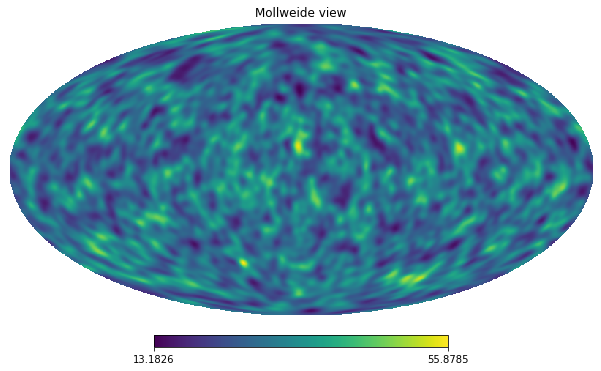

In [4]:
NSIDE = 2**10
NPIX = hp.nside2npix(NSIDE)
hp_map = np.zeros(NPIX)

size = 0.03

for i in range(len(z)):
    hp_map[hp.pixelfunc.ang2pix(NSIDE, 0.5 * np.pi - dec[i], ra[i])] += 1000
    if not i % 100:
        print("\r{}".format(np.round(100*(i+1)/len(z), 1)), end="%")

print("\r100%")

hp_map = hp.sphtfunc.smoothing(hp_map, sigma=size)

hp.fitsfunc.write_map('data/catalog_skymap.fits', hp_map, overwrite=True)
print("HEALPix Map written to file")

hp.mollview(hp_map)

In [5]:
masses = np.random.uniform(25,35,2)
index = np.random.randint(0, len(z))
sindist = bilby.core.prior.Sine()
cosdist = bilby.core.prior.Cosine()
powdist = bilby.core.prior.PowerLaw(2, minimum=100, maximum=1000)

injection_parameters = dict(mass_1=np.max(masses),
                            mass_2=np.min(masses),
                            a_1=np.random.uniform(0, 0.99),
                            a_2=np.random.uniform(0, 0.99),
                            tilt_1=sindist.sample(),
                            tilt_2=sindist.sample(),
                            phi_12=np.random.uniform(0, 2*np.pi),
                            phi_jl=np.random.uniform(0, 2*np.pi),
                            luminosity_distance=dl[index],
                            theta_jn=sindist.sample(),
                            psi=np.random.uniform(0, np.pi),
                            phase=np.random.uniform(0, 2*np.pi),
                            geocent_time=np.random.uniform(1.1e9, 1.2e9),
                            ra=ra[index],
                            dec=dec[index]
                           )

In [6]:
c='''
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
hp_inject = np.zeros(NPIX)

hp_inject[hp.pixelfunc.ang2pix(NSIDE, 0.5 * np.pi - injection_parameters["dec"], injection_parameters['ra'])] += 1
hp_inject = hp.sphtfunc.smoothing(hp_inject, sigma=0.04)
hp_inject[hp_inject<0]=0
hp.mollview(hp_inject)
'''

In [7]:
#hp.fitsfunc.write_map('data/inject_skymap.fits', hp_inject, overwrite=True)

In [8]:
waveform_arguments = dict(waveform_approximant="IMRPhenomPv2",
                          reference_frequency=50.0,
                          minimum_frequency=minimum_frequency,
                          catch_waveform_errors=True
                         )

waveform_generator = bilby.gw.WaveformGenerator(duration=duration,
                                                sampling_frequency=sampling_frequency,
                                                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                                                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                                                waveform_arguments=waveform_arguments
                                               )

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])

ifos.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency,
                                                   duration=duration,
                                                   start_time=injection_parameters["geocent_time"] - 2
                                                  )

ifos.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)

15:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:20 bilby INFO    : Injected signal in H1:
15:20 bilby INFO    :   optimal SNR = 6.58
15:20 bilby INFO    :   matched filter SNR = 6.41-1.91j
15:20 bilby INFO    :   mass_1 = 28.649937399672403
15:20 bilby INFO    :   mass_2 = 25.210691445959274
15:20 bilby INFO    :   a_1 = 0.24541729443891327
15:20 bilby INFO    :   a_2 = 0.23066832771003262
15:20 bilby INFO    :   tilt_1 = 1.0594207032806116
15:20 bilby INFO    :   tilt_2 = 0.3564666573040817
15:20 bilby INFO    :   phi_12 = 3.073539014032305
15:20 bilby INFO    :   phi_jl = 5.830401010479998
15:20 bilby INFO    :   luminosity_distance = 835.0821667196226
15:20 bilby INFO    :   theta_jn = 2.002374096398185
15:20 bilby INFO    :   psi = 1.3945247119554023
15:20 bilby INFO    :   phase = 

[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [9]:
prior = bilby.gw.prior.BBHPriorDict()
for key in ["mass_1",
            "mass_2",
            "a_1",
            "a_2",
            "tilt_1",
            "tilt_2",
            "theta_jn",
            "phi_12",
            "phi_jl",
            "psi",
            "phase",
           ]:
    prior[key] = injection_parameters[key]

prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=np.min(dl), maximum=2000, unit='Mpc', latex_label='$d_L$')
prior["geocent_time"] = bilby.core.prior.Uniform(injection_parameters['geocent_time']-0.1, injection_parameters['geocent_time']+0.1, name="geocent_time")
prior.pop("chirp_mass")
prior.pop("mass_ratio")

# hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/catalog_skymap.fits')
# prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
# prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')

likelihood = bilby.gw.GravitationalWaveTransient(interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                                                 time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

15:20 bilby INFO    : No prior given, using default BBH priors in /home/imcmahon/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
15:20 bilby INFO    : Loaded distance marginalisation lookup table does not match for distance_array.
15:20 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [10]:
result = bilby.run_sampler(likelihood=likelihood,
                           priors=prior,
                           sampler="dynesty",
                           npoints=1000,
                           injection_parameters=injection_parameters,
                           outdir=outdir,
                           label=label,
                           conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
                          )

15:20 bilby INFO    : Running for label 'skymap-injection', output will be saved to 'short_inject'
15:20 bilby INFO    : Using lal version 7.1.7
15:20 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
15:20 bilby INFO    : Using lalsimulation version 3.1.2
15:20 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
15:20 bilby INFO    : Search parameters:
15:20 bilby INFO    :   dec = Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
15:20 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='peri

0it [00:00, ?it/s]

15:20 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fb225a67100>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
15:20 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:20 bilby INFO    : Using dynesty version 1.0.1
15:20 bilby INFO    : Using the bi

15:53 bilby INFO    : Sampling time: 0:32:20.736067
15:53 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/11544 [00:00<?, ?it/s]

15:55 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/11544 [00:00<?, ?it/s]

15:55 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/11544 [00:00<?, ?it/s]

15:56 bilby INFO    : Summary of results:
nsamples: 11544
ln_noise_evidence: -7949.177
ln_evidence: -7907.067 +/-  0.117
ln_bayes_factor: 42.110 +/-  0.117



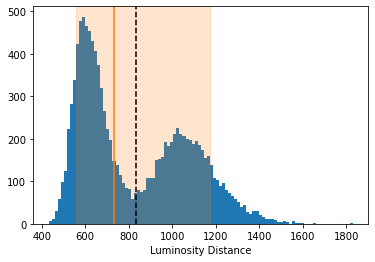

In [11]:
dl = result.posterior["luminosity_distance"].values
lower_bound = np.quantile(dl, 0.1)
upper_bound = np.quantile(dl, 0.9)
median = np.median(dl)

fig, ax = pylab.subplots()
ax.hist(dl, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['luminosity_distance'], color='k', linestyle='--')
ax.set_xlabel("Luminosity Distance")
pylab.show()

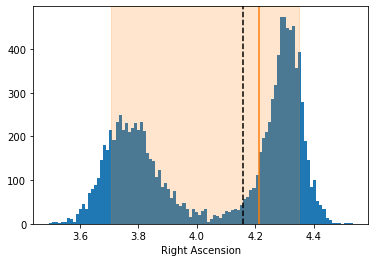

In [12]:
ra = result.posterior["ra"].values
lower_bound = np.quantile(ra, 0.1)
upper_bound = np.quantile(ra, 0.9)
median = np.median(ra)

fig, ax = pylab.subplots()
ax.hist(ra, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['ra'], color='k', linestyle='--')
ax.set_xlabel("Right Ascension")
pylab.show()

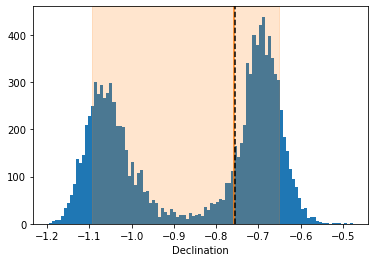

In [13]:
dec = result.posterior["dec"].values
lower_bound = np.quantile(dec, 0.1)
upper_bound = np.quantile(dec, 0.9)
median = np.median(dec)

fig, ax = pylab.subplots()
ax.hist(dec, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['dec'], color='k', linestyle='--')
ax.set_xlabel("Declination")
pylab.show()

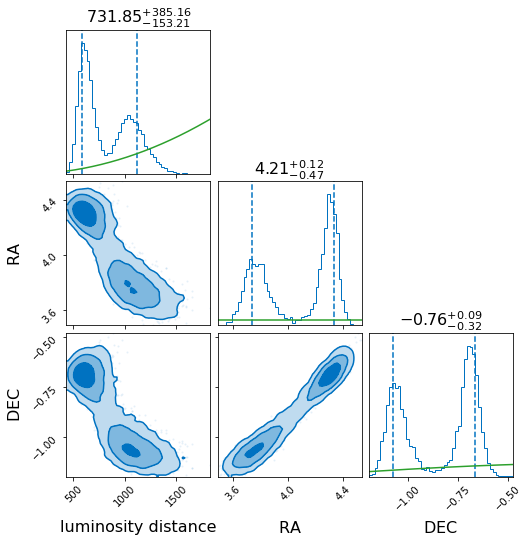

In [14]:
result.plot_corner(parameters=["luminosity_distance", "ra", 'dec'], priors=prior)

In [15]:
result.save_posterior_samples()

15:56 bilby INFO    : Writing samples file to /home/imcmahon/Documents/skymap-inference/short_inject/skymap-injection_posterior_samples.dat


In [16]:
! ligo-skymap-from-samples --maxpts 1000 short_inject/skymap-injection_posterior_samples.dat

2022-07-21 15:56:07,722 INFO reading samples
2022-07-21 15:56:07,852 INFO taking random subsample of chain
2022-07-21 15:56:07,861 INFO clustering ...
100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  6.03it/s]
2022-07-21 15:56:41,019 INFO clustering ...
100%|█████████████████████████████████████████| 200/200 [00:16<00:00, 12.01it/s]
2022-07-21 15:56:57,675 INFO pickling
2022-07-21 15:56:57,676 INFO making skymap
adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...
evaluating distance layers ...
100%|███████████████████████████████████| 16896/16896 [00:02<00:00, 6814.38it/s]


In [17]:
! ligo-skymap-plot skymap.fits -o skymap.png --annotate --contour 50 90

In [18]:
#! ligo-skymap-plot-volume skymap.fits -o skymap-volume.png

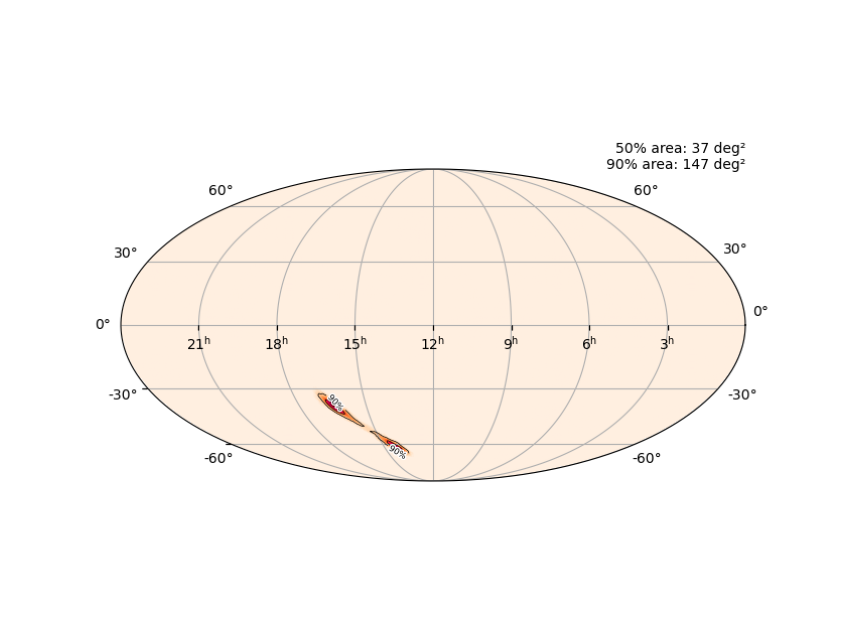

In [19]:
fig, ax = pylab.subplots(dpi=200)
plt.axis('off')
plot = ax.imshow(img.imread('skymap.png'))

In [20]:
#fig, ax = pylab.subplots(dpi=200)
#plt.axis('off')
#plot = ax.imshow(img.imread('skymap-volume.png'))

In [21]:
m = mhealpy.HealpixMap.read_map('skymap.fits')
m = m.rasterize(m.nside, 'RING')
m.data[m.data<1e-5] = 0

In [22]:
m.write_map('skymap_rasterize.fits', overwrite=True)

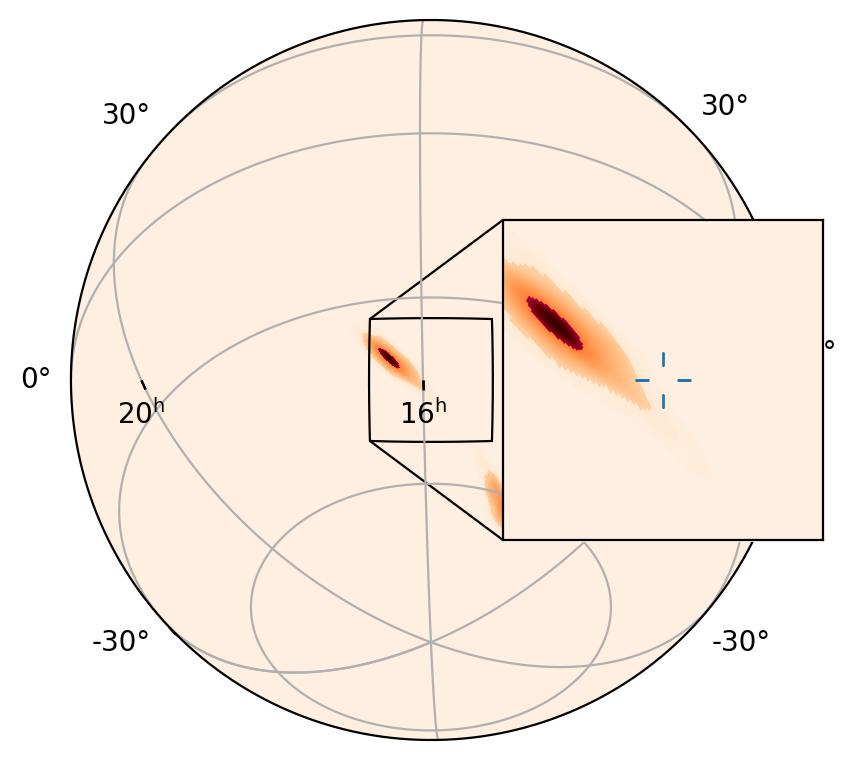

In [23]:
fig = plt.figure(figsize=(4, 4), dpi=200)
center = (np.round(injection_parameters['ra']*180/np.pi, 2), np.round(injection_parameters['dec']*180/np.pi, 2))

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center='{}d {}d'.format(center[0], center[1]))

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center='{}d {}d'.format(center[0], center[1]),
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')

ax.imshow_hpx('skymap_rasterize.fits', cmap='cylon')
ax_inset.imshow_hpx('skymap_rasterize.fits', cmap='cylon')
ax_inset.plot(
    center[0], center[1],
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=20,
    markeredgewidth=1)

In [24]:
waveform_arguments = dict(waveform_approximant="IMRPhenomPv2",
                          reference_frequency=50.0,
                          minimum_frequency=minimum_frequency
                         )

waveform_generator = bilby.gw.WaveformGenerator(duration=duration,
                                                sampling_frequency=sampling_frequency,
                                                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                                                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                                                waveform_arguments=waveform_arguments
                                               )

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])

ifos.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency,
                                                   duration=duration,
                                                   start_time=injection_parameters["geocent_time"] - 2
                                                  )

ifos.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)

15:57 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:57 bilby INFO    : Injected signal in H1:
15:57 bilby INFO    :   optimal SNR = 6.58
15:57 bilby INFO    :   matched filter SNR = 7.94-1.00j
15:57 bilby INFO    :   mass_1 = 28.649937399672403
15:57 bilby INFO    :   mass_2 = 25.210691445959274
15:57 bilby INFO    :   a_1 = 0.24541729443891327
15:57 bilby INFO    :   a_2 = 0.23066832771003262
15:57 bilby INFO    :   tilt_1 = 1.0594207032806116
15:57 bilby INFO    :   tilt_2 = 0.3564666573040817
15:57 bilby INFO    :   phi_12 = 3.073539014032305
15:57 bilby INFO    :   phi_jl = 5.830401010479998
15:57 bilby INFO    :   luminosity_distance = 835.0821667196226
15:57 bilby INFO    :   theta_jn = 2.002374096398185
15:57 bilby INFO    :   psi = 1.3945247119554023
15:57 bilby INFO    :   phase = 

[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [26]:
prior = bilby.gw.prior.PriorDict()
for key in ["mass_1",
            "mass_2",
            "a_1",
            "a_2",
            "tilt_1",
            "tilt_2",
            "theta_jn",
            "phi_12",
            "phi_jl",
            "psi",
            "phase",
           ]:
    prior[key] = injection_parameters[key]

prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=np.min(dl), maximum=2000, unit='Mpc', latex_label='$d_L$')
prior["geocent_time"] = bilby.core.prior.Uniform(injection_parameters['geocent_time']-0.1, injection_parameters['geocent_time']+0.1, name="geocent_time")

hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/catalog_skymap.fits', names=['ra', 'dec'], bounds={'ra': (0, 2*np.pi), 'dec': (-np.pi/2, np.pi/2)})
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')

likelihood = bilby.gw.GravitationalWaveTransient(interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                                                 time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

15:58 bilby INFO    : Loaded distance marginalisation lookup table does not match for distance_array.
15:58 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [27]:
result_hp = bilby.run_sampler(likelihood=likelihood,
                           priors=prior,
                           sampler="dynesty",
                           npoints=1000,
                           injection_parameters=injection_parameters,
                           outdir=outdir,
                           label='skymap-injection-hp',
                           conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
                          )

15:58 bilby INFO    : Running for label 'skymap-injection-hp', output will be saved to 'short_inject'
15:58 bilby INFO    : Using lal version 7.1.7
15:58 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
15:58 bilby INFO    : Using lalsimulation version 3.1.2
15:58 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
15:58 bilby INFO    : Search parameters:
15:58 bilby INFO    :   ra = HealPixPrior(dist=HealPixMapPriorDist(hp_file='data/catalog_skymap.fits', names=['ra', 'dec'], bounds={'ra': (0, 6.283185307179586), 'dec': (-1.5707963267948966, 1.5707963267948966)}, distance=False), name='ra', latex_label='$\\mathrm{RA}$', unit=None)
15:58 bilby INFO   

0it [00:00, ?it/s]

15:58 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fb21c9e6e80>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
15:58 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:58 bilby INFO    : Using dynesty version 1.0.1
15:58 bilby INFO    : Using the bi

16:31 bilby INFO    : Sampling time: 0:32:06.355472
16:31 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/11263 [00:00<?, ?it/s]

16:33 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/11263 [00:00<?, ?it/s]

16:33 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/11263 [00:00<?, ?it/s]

16:33 bilby INFO    : Summary of results:
nsamples: 11263
ln_noise_evidence: -8083.358
ln_evidence: -8047.231 +/-  0.116
ln_bayes_factor: 36.128 +/-  0.116



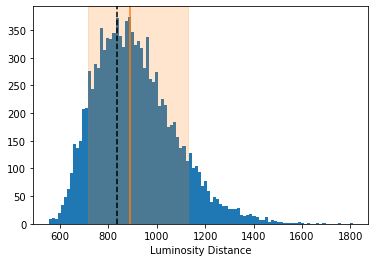

In [28]:
dl = result_hp.posterior["luminosity_distance"].values
lower_bound = np.quantile(dl, 0.1)
upper_bound = np.quantile(dl, 0.9)
median = np.median(dl)

fig, ax = pylab.subplots()
ax.hist(dl, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['luminosity_distance'], color='k', linestyle='--')
ax.set_xlabel("Luminosity Distance")
pylab.show()

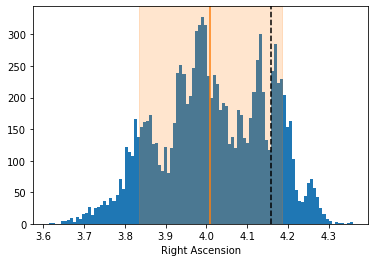

In [29]:
ra = result_hp.posterior["ra"].values
lower_bound = np.quantile(ra, 0.1)
upper_bound = np.quantile(ra, 0.9)
median = np.median(ra)

fig, ax = pylab.subplots()
ax.hist(ra, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['ra'], color='k', linestyle='--')
ax.set_xlabel("Right Ascension")
pylab.show()

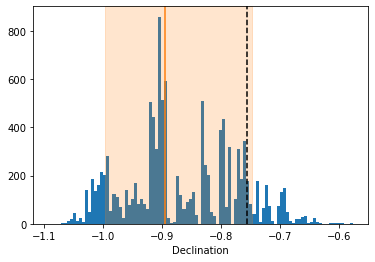

In [30]:
dec = result_hp.posterior["dec"].values
lower_bound = np.quantile(dec, 0.1)
upper_bound = np.quantile(dec, 0.9)
median = np.median(dec)

fig, ax = pylab.subplots()
ax.hist(dec, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['dec'], color='k', linestyle='--')
ax.set_xlabel("Declination")
pylab.show()

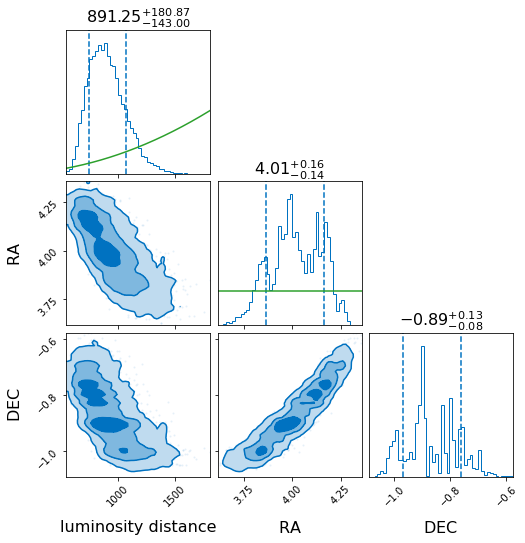

In [31]:
result_hp.plot_corner(parameters=["luminosity_distance", "ra", 'dec'], priors=prior)

In [32]:
result_hp.save_posterior_samples()

16:33 bilby INFO    : Writing samples file to /home/imcmahon/Documents/skymap-inference/short_inject/skymap-injection-hp_posterior_samples.dat


In [33]:
! ligo-skymap-from-samples --maxpts 1000 short_inject/skymap-injection-hp_posterior_samples.dat

2022-07-21 16:33:57,297 INFO reading samples
2022-07-21 16:33:57,461 INFO taking random subsample of chain
2022-07-21 16:33:57,469 INFO clustering ...
100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.12it/s]
2022-07-21 16:34:30,171 INFO clustering ...
100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.65it/s]
2022-07-21 16:34:47,335 INFO pickling
2022-07-21 16:34:47,337 INFO making skymap
adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...
evaluating distance layers ...
100%|███████████████████████████████████| 16896/16896 [00:02<00:00, 6717.81it/s]


In [34]:
m = mhealpy.HealpixMap.read_map('skymap.fits')
m = m.rasterize(m.nside, 'RING')
m.data[m.data<1e-5] = 0

In [35]:
m.write_map('skymap_rasterize_hp.fits', overwrite=True)

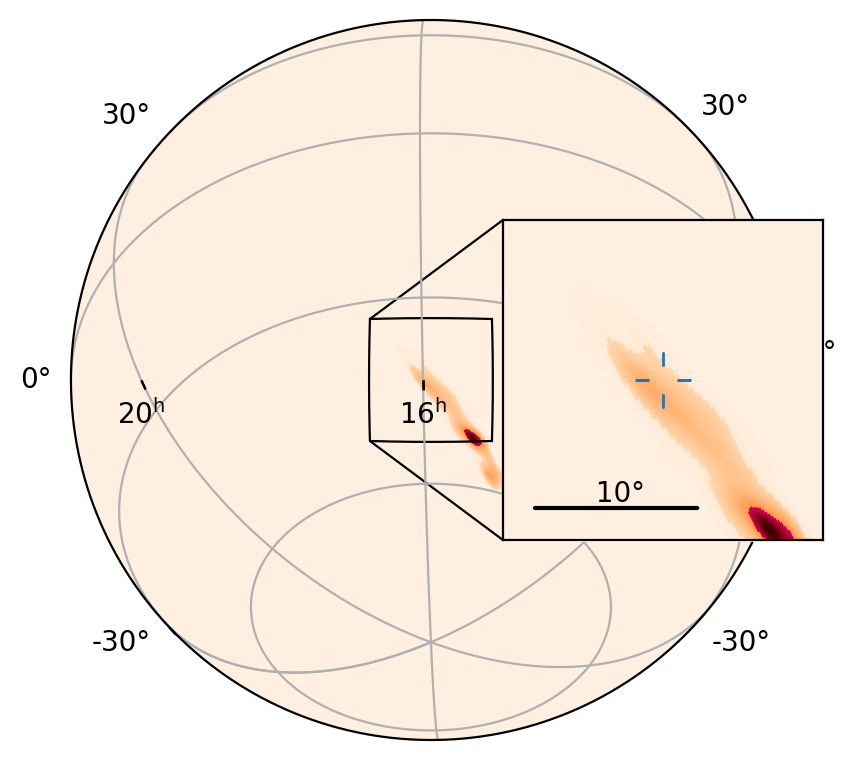

In [36]:
fig = plt.figure(figsize=(4, 4), dpi=200)
center = (np.round(injection_parameters['ra']*180/np.pi, 2), np.round(injection_parameters['dec']*180/np.pi, 2))

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center='{}d {}d'.format(center[0], center[1]))

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center='{}d {}d'.format(center[0], center[1]),
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')

ax_inset.scalebar((0.1, 0.1), 10 * u.deg).label()

ax.imshow_hpx('skymap_rasterize_hp.fits', cmap='cylon')
ax_inset.imshow_hpx('skymap_rasterize_hp.fits', cmap='cylon')
ax_inset.plot(
    center[0], center[1],
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=20,
    markeredgewidth=1)